# A context-sensitive spelling corrector

### In order to check, try **better_spell_corrector("sent")** function at the end of the notebook

This notebook focuses on word correction. It starts by analyzing typos, then selects the best correction based on the typo and its context (**bigram language model**). The main idea is the **noisy channel model**: a correct word is modified through a 'noisy' process. We find the original word by considering the probability of the 'noise' and the word's occurrence in a corpus (**unigram** and **bigrams**).

## Step 1

When a word is misspelled, there are several systematic ways in which it can be misspelled.
The 4 types of errors are:

- **deletion**: one letter is deleted
- **insertion**: one letter is inserted
- **transposition**: two letters are interchanged 
- **substitution**: one letter is substituted by another letter

In this step, I will proceed in developing functions for all 4 types of errors, which will give me all the variants of the input when the deletion, insertion, transposition, or substitution function has been applied. I assume that the mispellings have only an **edit distance of 1**, meaning that only one letter is mistakenly deleted/inserted/substituted or only one pair of letters is transposed.

In [660]:
def deletion(word):
    """A function that takes a string and returns a list of 
    strings with a removed character from that string"""
    l_delete = []  #empty list to populate
    for i in range(len(word)):  #indexing
        modified_word = word[:i] + word[i:][1:]  #e.g., hello, i = 0 --> "" + "ello" = "ello"
        l_delete.append(modified_word)  #append the modified version
    return list(set(l_delete))


def insertion(word):
    """Function that takes a string and gives a list of strings, 
    for each of which one letter is inserted between a pair of letters of the original string"""
    l_insert = []
    letters = 'abcdefghijklmnopqrstuvwxyz'  #we need letters to insert
    for i in range(len(word) + 1):  #indexing at length of the word+1 to allow for insertion after the end of the word
        for letter in letters:  #for loop to access each letter in the alphabet
            modified_word = word[:i] + letter + word[i:]  #insert letter in between word until i and word from i on
            l_insert.append(modified_word)  #append modified word
    return list(set(l_insert))  #return list


def transposition(word):
    """Function that takes a string and returns a list of
    strings where two characters have been exchanged"""
    l_transpose = []  #empty list
    list_char = [x for x in word]  #we need a list here in order to exchange letters, since strings are immutable
    for i in range(
            len(list_char) - 1):  #length-1 because later we will index at i+1, so we need to stop one before the end of the word
        list_char[i], list_char[i + 1] = list_char[i + 1], list_char[i]  #swap characters by exchanging them in the list
        modified_word = ''.join(list_char)  #convert the list into a string
        l_transpose.append(modified_word)  #append the modified_word to the list
        list_char = [x for x in word]  #reset list
    return list(set(l_transpose))


def substitution(word):
    """A function that takes a string and returns a list of candidates
    where one letter has been exchanged for another letter of the alphabet"""
    letters = 'abcdefghijklmnopqrstuvwxyz'
    l_substitute = []
    list_char = [x for x in word]  #convert string into list so it can be modified
    for i in range(len(list_char)):  #indexing with just the length of the list
        for letter in letters:
            list_char[i] = letter  #swap characters
            modified_word = ''.join(list_char)  #convert list into string
            l_substitute.append(modified_word)  #append modified word
            list_char = [x for x in word]  #reset list
    return l_substitute

### Unifying the functions

In [661]:
def set_confusion(word):
    """Function that takes a string and returns a set of edits of that word"""
    return list(set(substitution(word) + insertion(word) + transposition(word) + deletion(word)))

In [662]:
set_confusion("acress")

['acreso',
 'ackess',
 'acressu',
 'acresa',
 'wacress',
 'aceress',
 'acreis',
 'ascress',
 'aeress',
 'acres',
 'achress',
 'acxress',
 'acyress',
 'aceess',
 'gcress',
 'acrews',
 'alcress',
 'acressf',
 'atcress',
 'acretss',
 'oacress',
 'acresqs',
 'acfress',
 'acgress',
 'acuess',
 'actess',
 'eacress',
 'bcress',
 'macress',
 'acgess',
 'hcress',
 'acriss',
 'adcress',
 'acrcss',
 'acrets',
 'acsess',
 'acreses',
 'acressy',
 'acreqs',
 'ocress',
 'acresk',
 'acoess',
 'acreszs',
 'acrless',
 'across',
 'acrhss',
 'acruss',
 'acresc',
 'acrjess',
 'aocress',
 'acroess',
 'aciress',
 'acressz',
 'acresu',
 'akress',
 'acrehs',
 'ahress',
 'sacress',
 'acmress',
 'acresx',
 'ucress',
 'acrens',
 'acressr',
 'acrests',
 'acrejss',
 'acrwss',
 'axress',
 'acresvs',
 'acpress',
 'acmess',
 'hacress',
 'ahcress',
 'aress',
 'acdess',
 'acressp',
 'ecress',
 'acrses',
 'acresas',
 'acressk',
 'acess',
 'acrezss',
 'acjess',
 'acryess',
 'acregss',
 'acreuss',
 'acresjs',
 'scress',
 '

## Step 2: Possible candidates

### Step 2.1: Importing the lexical resource

In [663]:
import nltk
from nltk import word_tokenize

nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SunagatullinAyaz\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [664]:
vocab = set([x.lower() for x in words.words()])  #making a set so it is more efficient

In [665]:
with open("big.txt", "r") as big:
    read_big = big.read()
    big_txt = [word.lower() for word in word_tokenize(read_big)]

In [666]:
lexicon_comb = set(list(vocab) + list(set(big_txt)))  #combining

In [667]:
def english_word(word):
    if word in lexicon_comb:
        return True

#### A list of candidate possible words

In [668]:
def intended_possible_words(typo):
    """Function that takes a word and returns a list of possible English
    intended words"""
    list_words = []
    s_c = set_confusion(typo)  #all the words that come out of the noisy channel
    for word in s_c:
        if english_word(word):  #if the word is an English word
            list_words.append(word)
    if len(list_words) > 0:
        return list_words
    else:
        return []

In [669]:
intended_possible_words("acress")

['acres', 'across', 'cress', 'access', 'caress', 'actress']

## Step 3: The noisy channel: probabilities of intended words

The noisy channel model posits that in order to get the probability of a word being misspelled as another word, you have to calculate the **prior** of that word (absolute probability of a word) multiplied by the **error model** or **likelihood** (conditional probability of **a character appearing instead/before another character or other permutations**) ([Jurafsky and Martin, 2020, p. 3](https://web.stanford.edu/~jurafsky/slp3/B.pdf)). Then, an argmax function is applied, where the function with the best probability has to be selected. This is the formula for the **noisy channel probability**:


P(candidate) = P(typo_char|target_char) * P(candidate)
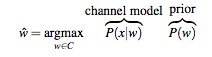

### Step 3.1: Calculating the prior

We start with the **prior**, since it is simpler to calculate (just the probability of the word occurring in a corpus).

Made a count dictionary function:

In [670]:
def dict_freq(corpus):
    """Function that takes a corpus in the form of a list and returns the frequency of each word"""
    d_freq = {}
    for word in corpus:
        if word not in d_freq:
            d_freq[word] = 1
        else:
            d_freq[word] += 1
    freq = {k: v for k, v in
            sorted(d_freq.items(), key=lambda x: x[1], reverse=True)}  #sort by frequency, descending order
    return freq

In [671]:
freq_big_corpus = dict_freq(big_txt)

freq_big_corpus

{'the': 79409,
 ',': 77142,
 '.': 48780,
 'of': 40017,
 'and': 38258,
 'to': 28679,
 'in': 21932,
 'a': 21042,
 "''": 13682,
 'that': 12487,
 '``': 12427,
 'he': 12383,
 'was': 11425,
 'it': 10648,
 'his': 10033,
 'is': 9816,
 'with': 9739,
 'as': 8058,
 'i': 7642,
 'had': 7394,
 'for': 6922,
 'not': 6899,
 'at': 6785,
 'by': 6675,
 'on': 6632,
 'be': 6154,
 'from': 5680,
 'but': 5639,
 'you': 5570,
 '--': 5565,
 'or': 5348,
 'her': 5283,
 'him': 5225,
 "'s": 5129,
 'which': 4839,
 '!': 4345,
 'were': 4296,
 '?': 4155,
 'all': 4123,
 'this': 4057,
 'she': 3938,
 'they': 3927,
 'are': 3646,
 'have': 3517,
 ';': 3511,
 'said': 3463,
 'an': 3417,
 'one': 3299,
 'who': 3044,
 'what': 2990,
 'so': 2955,
 'their': 2955,
 'there': 2954,
 'when': 2917,
 'been': 2599,
 'may': 2549,
 'if': 2366,
 'no': 2332,
 'up': 2250,
 'my': 2240,
 'them': 2240,
 'into': 2124,
 'do': 2027,
 'more': 1995,
 'would': 1978,
 'out': 1968,
 'pierre': 1949,
 'did': 1939,
 'prince': 1931,
 'me': 1916,
 'we': 1886,
 '

The absolute probability function is given by the **count of a word** divided by the **length of the corpus**:

In [672]:
def abs_prob_dict(corpus):
    """Function that takes a corpus and returns a sorted dictionary of probabilities for each word"""
    prob = {k: v / len(corpus) for k, v in sorted(dict_freq(corpus).items(), key=lambda x: x[1], reverse=True)}
    return prob

In [673]:
abs_prob_big = abs_prob_dict(big_txt)
abs_prob_big

{'the': 0.061627112856411134,
 ',': 0.059867757306719234,
 '.': 0.03785679916805066,
 'of': 0.03105607897310134,
 'and': 0.02969096807239201,
 'to': 0.022256973008210845,
 'in': 0.017020814254893137,
 'a': 0.016330110047029972,
 "''": 0.010618219069644714,
 'that': 0.009690812857963277,
 '``': 0.009644248529343287,
 'he': 0.009610101355021963,
 'was': 0.00886662424138948,
 'it': 0.008263616185760629,
 'his': 0.007786331817405746,
 'is': 0.007617924162230121,
 'with': 0.007558166607167802,
 'as': 0.0062535893336644575,
 'i': 0.005930743321899204,
 'had': 0.005738277430269918,
 'for': 0.005371971378459342,
 'not': 0.005354121719155012,
 'at': 0.005265649494777034,
 'by': 0.0051802815589737225,
 'on': 0.005146910456796064,
 'be': 0.0047759479721234885,
 'from': 0.004408089776025579,
 'but': 0.004376270818135254,
 'you': 0.0043227218402222675,
 '--': 0.004318841479503934,
 'or': 0.00415043382432831,
 'her': 0.004099989134989989,
 'him': 0.004054976950657333,
 "'s": 0.0039804740248653514,
 

### Step 3.2: Possible words using a unigram language model 

This is an example of a **unigram language model** (only one word taken into account). I used the *acress* example that was seen throughout this report already.

In [674]:
def abs_prob(typo, corpus):
    """Function that takes a typo in the form of a string and a corpus in the form of a list
    and returns a dictionary of probabilities for all possible correction candidates"""
    count = {}
    freq_ = dict_freq(corpus)
    for poss_word in intended_possible_words(typo):
        if poss_word in freq_.keys():
            count[poss_word] = (
                freq_[poss_word],
                '{0:.10f}'.format((freq_[poss_word]) / (len(corpus))))  #format up to 10 decimal places
        prob = {k: v for k, v in sorted(count.items(), key=lambda x: x[1], reverse=True)}
    return prob

Options for *acress* in the corpora:

In [675]:
acress_big = abs_prob("acress", big_txt)

In [676]:
import pandas as pd  #to make a nice table

pd.DataFrame.from_dict(acress_big, orient='index',
                       columns=['count(w)', 'p(w)'])

,count(w),p(w)
across,220,0.0001707359
access,56,0.0000434600
acres,36,0.0000279386
actress,7,0.0000054325
caress,3,0.0000023282


## Step 4: Error model/likelihood calculation: calculating the conditional probabilities of character permutations

In this section, I develop functions that will tell me the probabilities of some characters in the target being mistyped as some other characters in the typo. In order to do that, I used a [typo corpus](http://norvig.com/ngrams/spell-errors.txt) by Norvig, made a dictionary out of it, and divided the typos corpus into the different **error-specific typo corpora** (deletion, insertion, substitution, transposition). 

For each created corpus, I then developed functions to give me **conditional probabilities** for character permutations in that specific error type. Finally, I developed functions that give the best candidates for each type of typo, which is the **noisy channel probability**.

### Step 4.1 Extracting and cleaning the typo corpus

In [677]:
import re
import editdistance

In [678]:
punctuation = r"[.!?:,]|\*[1-9]"  #to remove all strings with a number and/or punctuation
with open("spell-errors.txt", "r") as mistakes:
    spell_errors = []
    read_mistakes = mistakes.read()  #read
    split_lines = read_mistakes.split("\n")  #split with argument new line
    for line in split_lines:
        new_line = re.sub(punctuation, "",
                          line).lower()  #substitute any punctuation or number with an empty string and lower the line
        tok = word_tokenize(new_line)  #tokenize, so it becomes a list of word
        spell_errors.append(tok)  #append each tokenized line to the spell error list

In [679]:
spell_errors

[['raining', 'rainning', 'raning'],
 ['writings', 'writtings'],
 ['disparagingly', 'disparingly'],
 ['yellow', 'yello'],
 ['four', 'forer', 'fours', 'fuore', 'fore', 'for'],
 ['woods', 'woodes'],
 ['hanging', 'haing'],
 ['aggression', 'agression'],
 ['looking',
  'loking',
  'luing',
  'look',
  'locking',
  'lucking',
  'louk',
  'looing',
  'lookin',
  'liking'],
 ['eligible', 'eligble', 'elegable', 'eligable'],
 ['electricity', 'electrisity', 'electricty', 'electrizity'],
 ['scold', 'schold', 'skold'],
 ['adaptable', 'adabtable'],
 ['caned', 'canned', 'cained'],
 ['immature', 'imature'],
 ['should', "n't", 'shoudln', 'shouldnt'],
 ['swivel', 'swival'],
 ['appropriation', 'apropriation'],
 ['fur', 'furr', 'fer'],
 ['stabbed', 'stabed'],
 ['southwold', 'suothwode'],
 ['disturb', 'distrebe', 'desturb'],
 ['recollections', 'reclections', 'recolections'],
 ['prize', 'prise', 'prizer'],
 ['wednesday', 'wensday', 'wedensday'],
 ['succession', 'sucession', 'sucesion', 'succesion'],
 ['strai

Making a dictionary out of this list:

In [680]:
target_typos = {}
for line in spell_errors:
    target = line[0]  #first is always target
    typos = line[1:]  #rest is always typos
    for typo in typos:
        if editdistance.eval(target, typo) == 1 or typo in transposition(
                target):  #either edit distance one or transposition
            if target not in target_typos.keys():
                target_typos[target] = [typo]
            else:  #append typos to value of key already in dict
                target_typos[target].append(typo)

target_typos

{'raining': ['rainning', 'raning'],
 'writings': ['writtings'],
 'yellow': ['yello'],
 'four': ['fours', 'for'],
 'woods': ['woodes'],
 'aggression': ['agression'],
 'looking': ['loking', 'locking', 'looing', 'lookin'],
 'eligible': ['eligble', 'eligable'],
 'electricity': ['electrisity', 'electricty', 'electrizity'],
 'scold': ['schold', 'skold'],
 'adaptable': ['adabtable'],
 'caned': ['canned', 'cained'],
 'immature': ['imature'],
 'swivel': ['swival'],
 'appropriation': ['apropriation'],
 'fur': ['furr', 'fer'],
 'stabbed': ['stabed'],
 'disturb': ['desturb'],
 'recollections': ['recolections'],
 'prize': ['prise', 'prizer'],
 'wednesday': ['wedensday', 'wedensday'],
 'succession': ['sucession', 'succesion'],
 'straight': ['stright'],
 'incremented': ['increented'],
 'pulse': ['pluse'],
 'second': ['secand', 'secund', 'seconnd', 'seond'],
 'jamjar': ['jam_jar'],
 'sailed': ['saled', 'saild'],
 'thunder': ['thounder'],
 'cooking': ['coking', 'kooking', 'cocking'],
 'fossil': ['fossc

In [681]:
typos_target = {tuple(value): key for key, value in target_typos.items()}  #lists can't be keys

In [682]:
typos_target[('corer', 'coner', 'conner', 'croner')]

'corner'

### Step 4.2: Making error-specific corpora

Here, I am separating the typo dictionary in **4 error-type-specific dictionaries**, so that I can later compute the conditional probabilities for characters being deleted/inserted/transposed/substituted.

In [683]:
deletion_ = {}
insertion_ = {}
transposition_ = {}
substitution_ = {}
for typos in typos_target.keys():  #for each list of typos for each word
    for typo in typos:  #for each typo for the target
        if typo in deletion(typos_target[typos]):  #if the typo in a list of deletions for the target
            if typos_target[typos] not in deletion_:  #if the target is not in the deletion dict
                deletion_[typos_target[typos]] = [typo]  #populate dict
            else:
                deletion_[typos_target[typos]].append(typo)  #append if target is already in dict
        if typo in insertion(typos_target[typos]):
            if typos_target[typos] not in insertion_:
                insertion_[typos_target[typos]] = [typo]
            else:
                insertion_[typos_target[typos]].append(typo)
        if typo in transposition(typos_target[typos]):
            if typos_target[typos] not in transposition_:
                transposition_[typos_target[typos]] = [typo]
            else:
                transposition_[typos_target[typos]].append(typo)
        if typo in substitution(typos_target[typos]):
            if typos_target[typos] not in substitution_:
                substitution_[typos_target[typos]] = [typo]
            else:
                substitution_[typos_target[typos]].append(typo)

In [684]:
deletion_

{'raining': ['raning'],
 'yellow': ['yello'],
 'four': ['for'],
 'aggression': ['agression'],
 'looking': ['loking', 'looing', 'lookin'],
 'eligible': ['eligble'],
 'electricity': ['electricty'],
 'immature': ['imature'],
 'appropriation': ['apropriation'],
 'stabbed': ['stabed'],
 'recollections': ['recolections'],
 'succession': ['sucession', 'succesion'],
 'straight': ['stright'],
 'incremented': ['increented'],
 'second': ['seond'],
 'sailed': ['saled', 'saild'],
 'cooking': ['coking'],
 'increasing': ['incresing', 'inceasing'],
 'reporter': ['repoter'],
 'interrupting': ['interupting'],
 'here': ['her'],
 'atoms': ['atom'],
 'substance': ['substace'],
 'climbed': ['climed'],
 'controversy': ['controvery', 'controvesy'],
 'cancellation': ['cancelation'],
 'criticism': ['criticsm', 'critcism'],
 'divide': ['divid'],
 'sweetest': ['sweetes'],
 'explained': ['explaind', 'eplained', 'explaned'],
 'brought': ['broght', 'brough', 'bought'],
 'sizeable': ['sizable'],
 'spoke': ['spok'],
 

### Step 4.3: Computing the conditional probabilities for all error types and error-specific best candidate functions

In this section, I compute the conditional probabilities for each type of error.
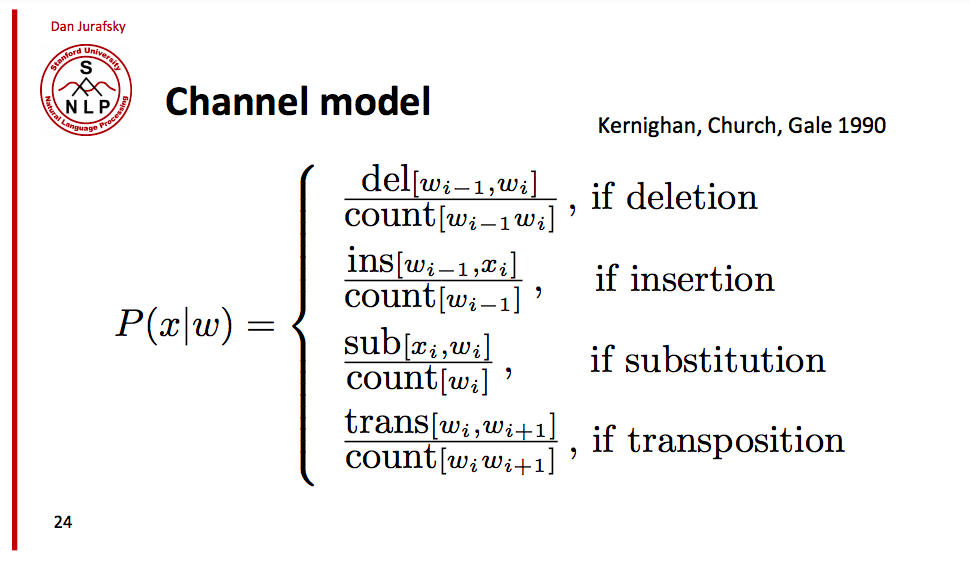

### Deletion:

Here, I need to calculate the **probability of xy mistyped as x** (so **deletion of y after x**):

**x|xy** --> typed **x** given that the correct is **xy**

In [685]:
def bigram(word):
    """Function that takes a word and returns a list with character bigrams of that word"""
    letters = [x for x in word]
    ngrams = zip(*[letters[i:] for i in range(2)])
    return ["".join(ngram) for ngram in ngrams]


bigram("hello")

['he', 'el', 'll', 'lo']

In [686]:
def bigram_count(typo_corpus):
    """Function that takes a typo corpus and returns a dictionary with frequencies for each bigram"""
    dd = {}
    for target in typo_corpus.keys():
        for bg in bigram(target):
            if bg not in dd.keys():
                dd[bg] = 1
            else:
                dd[bg] += 1
    return dd

In [687]:
bigrams_target = bigram_count(target_typos)
bigrams_target["unseen"] = 0  #we need unseen ones for later
bigrams_target

{'ra': 464,
 'ai': 152,
 'in': 1000,
 'ni': 221,
 'ng': 528,
 'wr': 17,
 'ri': 391,
 'it': 383,
 'ti': 642,
 'gs': 21,
 'ye': 30,
 'el': 318,
 'll': 312,
 'lo': 215,
 'ow': 115,
 'fo': 101,
 'ou': 329,
 'ur': 274,
 'wo': 54,
 'oo': 122,
 'od': 60,
 'ds': 46,
 'ag': 130,
 'gg': 44,
 'gr': 135,
 're': 758,
 'es': 596,
 'ss': 251,
 'si': 296,
 'io': 349,
 'on': 667,
 'ok': 36,
 'ki': 55,
 'li': 331,
 'ig': 128,
 'gi': 83,
 'ib': 68,
 'bl': 192,
 'le': 515,
 'ec': 239,
 'ct': 178,
 'tr': 230,
 'ic': 302,
 'ci': 169,
 'ty': 103,
 'sc': 123,
 'co': 436,
 'ol': 201,
 'ld': 50,
 'ad': 163,
 'da': 104,
 'ap': 141,
 'pt': 67,
 'ta': 285,
 'ab': 152,
 'ca': 248,
 'an': 523,
 'ne': 328,
 'ed': 645,
 'im': 146,
 'mm': 96,
 'ma': 222,
 'at': 596,
 'tu': 126,
 'sw': 28,
 'wi': 70,
 'iv': 134,
 've': 319,
 'pp': 125,
 'pr': 263,
 'ro': 341,
 'op': 113,
 'ia': 146,
 'fu': 68,
 'st': 475,
 'bb': 22,
 'be': 135,
 'di': 245,
 'is': 378,
 'rb': 24,
 'ns': 216,
 'iz': 36,
 'ze': 37,
 'we': 85,
 'dn': 6,
 's

In [688]:
def del_diff(target, typo):
    """Function that takes a target and a typo of deletion type and returns the character permutation in the form
    of conditional probability"""
    for i in range(len(target)):
        try:
            if target[i] != typo[i]:  #if letter at position i does not correspond
                if i != 0:  #if not the first letter
                    cond_prob = target[i - 1].lower() + "|" + target[
                                                              i - 1:i + 1].lower()  #to account for cases where the typo is in the first bigram
                    break  #to take only first difference
                if i == 0:  #if first letter, then the letter before is just empty space
                    cond_prob = "|" + target[i].lower()  #to account for cases where the typo is in the first bigram
                    break

        except IndexError:  #when i is not in the range of the typo (because deletion at last position)
            cond_prob = target[i - 1].lower() + "|" + target[
                                                      -2:].lower()  #last letter of typo (one less than i in target) given that it was supposed to be the last two of the target
            break
    return cond_prob

In [689]:
def occur_letter_zero_in_target(typo_corpus):
    """Function that takes a corpus typo and returns a dictionary of counts for each letter at position zero"""
    occ = {}
    for tar in typo_corpus.keys():
        letter_zero = tar[0]
        if letter_zero not in occ:
            occ[letter_zero] = 0
        else:
            occ[letter_zero] += 1
    return occ

In [690]:
letter_zero_count = {k: v for k, v in sorted(occur_letter_zero_in_target(target_typos).items(), key=lambda x: x[0])}
letter_zero_count["unseen"] = 0  #for later
letter_zero_count

{'a': 549,
 'b': 333,
 'c': 687,
 'd': 385,
 'e': 336,
 'f': 288,
 'g': 186,
 'h': 200,
 'i': 272,
 'j': 53,
 'k': 42,
 'l': 206,
 'm': 292,
 'n': 135,
 'o': 156,
 'p': 549,
 'q': 26,
 'r': 346,
 's': 779,
 't': 311,
 'u': 103,
 'v': 87,
 'w': 203,
 'y': 19,
 'z': 3,
 'unseen': 0}

In [691]:
def del_prob(del_typos):
    """Function that takes a corpus of deletion typos and returns a dictionary of all the conditional probabilities
    for character permutations"""
    cond_prob_list = []
    for target, typos in del_typos.items():  #for target and typos
        for typo in typos:
            cond_p = del_diff(target, typo)
            cond_prob_list.append(cond_p)

    counts = {}
    for cp in cond_prob_list:
        if cp not in counts:
            counts[cp] = 1
        else:
            counts[cp] += 1

    prob = {}
    for pair, count in counts.items():
        intend = pair.split("|")[1]  #take the second part, which is the intended characters
        if len(intend) == 2:
            prob[pair] = float(counts[pair] / bigrams_target[intend])
        else:  #if we are dealing with the beginning of the word, i decided to just divide by the letter count of the next word, which would correspond to ""|""x
            prob[pair] = float(counts[pair] / letter_zero_count[intend])

    prob_sorted = {k: v for k, v in sorted(prob.items(), key=lambda x: x[1], reverse=True)}

    return prob_sorted

In [692]:
del_prob(deletion_)

{'y|y_': 1.0,
 'k|k_': 1.0,
 'r|r_': 1.0,
 'o|o_': 1.0,
 'n|nx': 1.0,
 'g|gt': 1.0,
 's|s_': 1.0,
 'p|p_': 1.0,
 'w|w_': 1.0,
 'f|f_': 1.0,
 'w|wy': 1.0,
 'h|hh': 1.0,
 'e|e_': 0.8888888888888888,
 'g|gg': 0.8636363636363636,
 't|t_': 0.8571428571428571,
 'n|n_': 0.8461538461538461,
 'y|yc': 0.8,
 'm|mm': 0.7916666666666666,
 'c|cc': 0.7464788732394366,
 'p|pp': 0.744,
 'n|nn': 0.7317073170731707,
 'd|dd': 0.7272727272727273,
 'a|a_': 0.7142857142857143,
 't|tt': 0.6698113207547169,
 'o|o-': 0.6666666666666666,
 'm|m-': 0.6666666666666666,
 'd|d_': 0.6666666666666666,
 'x|xh': 0.6666666666666666,
 'r|rr': 0.616,
 'b|bb': 0.5909090909090909,
 'x|xc': 0.5909090909090909,
 'l|ll': 0.5480769230769231,
 's|ss': 0.5378486055776892,
 'e|ea': 0.5103857566765578,
 'w|w-': 0.5,
 'm|mn': 0.5,
 'h|hn': 0.5,
 'h|h-': 0.5,
 'l|l_': 0.5,
 't|tg': 0.5,
 'w|wh': 0.4878048780487805,
 'k|ks': 0.48,
 'o|oa': 0.46551724137931033,
 'f|ff': 0.46153846153846156,
 'c|cs': 0.45454545454545453,
 'a|ai': 0.453947

We need to use something called **Laplace or add-1 smoothing**.
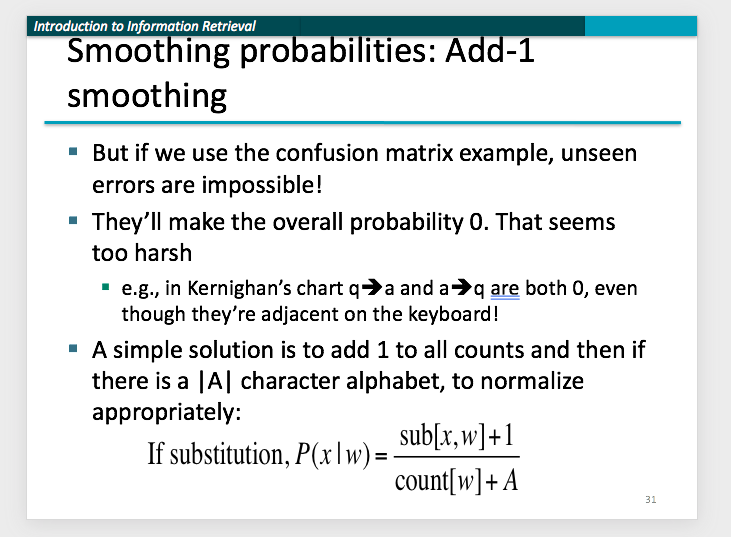

In [693]:
def del_prob_smooth(del_typos):
    """Function that takes a corpus of deletion typos and returns a dictionary of all the smoothed
    conditional probabilities for character permutations"""
    cond_prob_list = []
    for target, typos in del_typos.items():  #for target and typos
        for typo in typos:
            cond_p = del_diff(target, typo)
            cond_prob_list.append(cond_p)

    counts = {}
    for cp in cond_prob_list:
        if cp not in counts:
            counts[cp] = 1
        else:
            counts[cp] += 1

    prob = {}
    for pair, count in counts.items():
        intend = pair.split("|")[1]  #take the second part, which is the intended character/bigram
        if len(intend) == 2:  #if we are indeed dealing with a bigram (deletion not at the beginning of the word)
            prob[pair] = float((counts[pair] + 1) / ((bigrams_target[intend]) + (
                len(bigrams_target))))  #adding 1 to count and length of bigram list to denominator
        else:
            prob[pair] = float((counts[pair] + 1) / ((letter_zero_count[intend]) + (
                len(letter_zero_count))))  #if we are dealing with the beginning of the word, i decided to just divide by the letter count of the next word, which would correspond to ""|""x

    prob_sorted = {k: v for k, v in sorted(prob.items(), key=lambda x: x[1], reverse=True)}
    return prob_sorted

In [694]:
cond_prob_del = del_prob_smooth(deletion_)
cond_prob_del

{'l|ll': 0.20259128386336867,
 'e|ea': 0.19794050343249428,
 's|ss': 0.17258883248730963,
 '|k': 0.16176470588235295,
 'p|pp': 0.1419939577039275,
 'm|mm': 0.12164296998420221,
 'r|rr': 0.11782477341389729,
 'o|ou': 0.11200923787528869,
 't|tt': 0.1119751166407465,
 'e|ee': 0.10638297872340426,
 'a|ai': 0.10159651669085631,
 'n|nn': 0.09854604200323101,
 'r|re': 0.09420849420849421,
 'n|ne': 0.09017341040462427,
 'c|cc': 0.08881578947368421,
 'o|oo': 0.07132018209408195,
 't|te': 0.06852791878172589,
 'g|gg': 0.06712564543889846,
 '|w': 0.06550218340611354,
 'e|es': 0.06001765225066196,
 'c|ci': 0.05807365439093484,
 's|se': 0.05701754385964912,
 'o|ow': 0.05674846625766871,
 't|ts': 0.05547226386806597,
 'n|ns': 0.05444887118193891,
 'v|ve': 0.053738317757009345,
 'n|ni': 0.052770448548812667,
 'g|ge': 0.05234159779614325,
 'm|me': 0.05166475315729047,
 'f|ff': 0.05149501661129568,
 'l|le': 0.051330798479087454,
 'a|ar': 0.05019685039370079,
 'i|ie': 0.04980340760157274,
 't|tr': 0.04

Now it's time to develop the function that will give the best candidates given that the typo is of type **deletion**.

In [695]:
def del_best_match(typo):
    """Function that takes a typo and returns a dictionary with smoothed probabilities of the best candidates, given that
    the typo is of deletion-type, and the best candidate"""
    d = {}
    for word in intended_possible_words(typo):
        if typo in deletion(word):
            if word in abs_prob_big.keys():  #if the word is in our dictionary that gives absolute probabilities
                try:  #if the character confusion is present in the deletion count dictionary
                    cond_p = del_diff(word, typo)
                    d[word] = '{0:.10f}'.format((cond_prob_del[cond_p]) * abs_prob_big[
                        word])  #multiply the conditional probability we got from the typo corpus with the absolute probability of the possible word that was meant
                except KeyError:  #if character confusion not present in the deletion count dictionary
                    cond_p = del_diff(word, typo)
                    split = cond_p.split("|")  #split into typed and intended
                    intend = split[1]
                    if len(intend) == 2:  #if intended is a bigram
                        try:
                            d[word] = '{0:.10f}'.format(((1 / (bigrams_target[intend] + len(bigrams_target))) *
                                                         abs_prob_big[word]))  #count of 1
                        except KeyError:  #if the bigram is not in the bigrams target
                            d[word] = '{0:.10f}'.format(((1 / (bigrams_target["unseen"] + len(bigrams_target))) *
                                                         abs_prob_big[word]))  #count of 0+length of the bigrams target
                    else:
                        try:
                            d[word] = '{0:.10f}'.format(
                                (1 / (letter_zero_count[intend] + len(letter_zero_count))) * abs_prob_big[
                                    word])  #count of 1
                        except KeyError:  #if the letter is unseen in the letter_zero_count
                            d[word] = '{0:.10f}'.format(
                                (1 / (letter_zero_count["unseen"] + len(letter_zero_count))) * abs_prob_big[
                                    word])  #count of 0+length of the bigrams target

    d = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
    if len(d) > 0:  #if the dictionary is not empty
        return d, max(d, key=d.get)
    else:
        return d,

In [696]:
del_best_match("he")

({'the': '0.0007314791',
  'her': '0.0001544834',
  'she': '0.0000455578',
  'hen': '0.0000001800',
  'hey': '0.0000000850',
  'hem': '0.0000000290',
  'hue': '0.0000000165',
  'heh': '0.0000000056',
  'hew': '0.0000000014'},
 'the')

### Insertion

Here, I do exactly the same as I did for the deletion function, except I change the mechanism of detecting the difference. Indeed, here we are looking for:

**x|y** --> inserting an **x** after a **y**

In [698]:
def insert_diff(target, typo):
    """Function that takes a target and a typo of insertion type and returns the character permutation in the form
    of conditional probability"""
    global cond_p_ins
    if typo[-1] != target[-1]:  #if the insertion occurs at last position
        cond_p_ins = typo[-1].lower() + "|" + target[
            -1].lower()  #insertion at the last letter position given the last letter of the target word
    for i in range(
            len(target)):  #take the shorter one not to incur in index errors (last position already accounted for in first condition)
        if target[i] != typo[i]:  #comparison
            if i != 0:  #if letter not inserted at position 0
                cond_p_ins = typo[i].lower() + "|" + target[
                    i - 1].lower()  #insertion of a letter given another letter seen before
                break
            if i == 0:  #if insertion occurs at first position: x given "" before
                cond_p_ins = typo[i].lower() + "|"
                break
    return cond_p_ins

In [699]:
insert_diff("hello", "helflo")

'f|l'

In [700]:
def occur_letter_in_target(typo_corpus):
    """Function that takes a typo corpus and returns a dictionary with the number occurrences for each letter
    in the corpus"""
    occ = {}
    for tar in typo_corpus.keys():
        for letter in tar:
            if letter not in occ:
                occ[letter] = 0
            else:
                occ[letter] += 1
    return occ

In [701]:
letter_count_target = {k: v for k, v in sorted(occur_letter_in_target(target_typos).items(), key=lambda x: x[0])}
letter_count_target["unseen"] = 0
letter_count_target

{"'": 0,
 '-': 93,
 '_': 66,
 'a': 3772,
 'b': 819,
 'c': 2205,
 'd': 1882,
 'e': 6100,
 'f': 693,
 'g': 1299,
 'h': 1054,
 'i': 3956,
 'j': 83,
 'k': 348,
 'l': 2507,
 'm': 1394,
 'n': 3529,
 'o': 3058,
 'p': 1540,
 'q': 93,
 'r': 3578,
 's': 3388,
 't': 3428,
 'u': 1588,
 'v': 559,
 'w': 458,
 'x': 142,
 'y': 932,
 'z': 65,
 'unseen': 0}

In [702]:
def insert_prob_smooth(insert_typos):
    """Function that takes a corpus of insertion typos and returns a dictionary of all the smoothed
    conditional probabilities for character permutations"""
    cond_prob_l = []
    for target, typos in insert_typos.items():  #for target and typos
        for typo in typos:
            c_p = insert_diff(target, typo)
            cond_prob_l.append(c_p)

    counts = {}
    for cp in cond_prob_l:
        if cp not in counts:
            counts[cp] = 1
        else:
            counts[cp] += 1

    prob = {}
    for pair, count in counts.items():
        letter_before = pair.split("|")[1]  #take the second part, which is the letter before the inserted letter
        if letter_before != '':  #if insertion not at position zero
            prob[pair] = (counts[pair] + 1) / (
                    letter_count_target[letter_before] + len(letter_count_target))  #smoothed probability
        else:  #if insertion at position zero
            prob[pair] = (counts[pair] + 1) / (len(target_typos) + len(
                target_typos))  #divided by all the times there is empty space in position zero, hence all words

    prob_sorted = {k: v for k, v in sorted(prob.items(), key=lambda x: x[1], reverse=True)}
    return prob_sorted

In [703]:
cond_prob_insert = insert_prob_smooth(insertion_)
cond_prob_insert

{'s|x': 0.12209302325581395,
 'c|x': 0.0872093023255814,
 'e|k': 0.06613756613756613,
 'l|l': 0.039416633819471816,
 'e|w': 0.0389344262295082,
 'f|f': 0.03872752420470263,
 'm|m': 0.037921348314606744,
 'e|h': 0.03505535055350553,
 'h|w': 0.03278688524590164,
 'e|v': 0.03225806451612903,
 'e|t': 0.029496818970503182,
 'h|x': 0.029069767441860465,
 'e|p': 0.024840764331210193,
 'e|l': 0.024438312968072525,
 'e|d': 0.02405857740585774,
 'e|m': 0.023876404494382022,
 'e|r': 0.023558758314855877,
 'i|v': 0.022071307300509338,
 'u|o': 0.021373056994818652,
 's|s': 0.021357519016968987,
 'z|z': 0.021052631578947368,
 'w|_': 0.020833333333333332,
 'e|n': 0.02051137960101152,
 'e|g': 0.020316027088036117,
 't|t': 0.01850780798149219,
 'r|r': 0.018292682926829267,
 'p|p': 0.017834394904458598,
 'o|j': 0.017699115044247787,
 'u|j': 0.017699115044247787,
 'e|s': 0.017261556465769455,
 'c|c': 0.017002237136465325,
 'r|u': 0.01668726823238566,
 'e|y': 0.016632016632016633,
 'q|q': 0.01626016260162

In [704]:
def insert_best_match(typo):
    """Function that takes a typo and returns a dictionary with smoothed probabilities of the best candidates, given that
    the typo is of insertion-type, and the best candidate"""
    d = {}
    for word in intended_possible_words(typo):
        if typo in insertion(word):
            if word in abs_prob_big.keys():
                try:
                    cond_p = insert_diff(word, typo)
                    d[word] = '{0:.10f}'.format((cond_prob_insert[cond_p]) * abs_prob_big[
                        word])  #multiply the conditional probability we got from the typo corpus with the absolute probability of the possible 
                except KeyError as e:
                    cond_p = insert_diff(word, typo)
                    split = cond_p.split("|")  #split into typed and intended
                    intend = split[1]
                    if intend != '':  #if insertion doesn't happen in position zero
                        try:
                            d[word] = '{0:.10f}'.format(
                                (1 / (letter_count_target[intend] + len(letter_count_target))) * abs_prob_big[
                                    word])  #count of 1
                        except KeyError:  #if the letter in target that insert follows is unseen in the letter_count_target
                            d[word] = '{0:.10f}'.format(
                                (1 / (letter_count_target["unseen"] + len(letter_count_target))) * abs_prob_big[
                                    word])  #cou
                    else:  #if insertion happens in position zero
                        d[word] = '{0:.10f}'.format(
                            (1 / (len(letter_count_target) + len(letter_count_target))) * abs_prob_big[
                                word])  #count of 1

    d = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
    if len(d) > 0:
        return d, max(d, key=d.get)
    else:
        return d,

In [705]:
insert_best_match("strain")

({'stain': '0.0000000361', 'train': '0.0000000101'}, 'stain')

### Transposition

Again, same process, except we need:

**yx|xy** --> typed **yx** given intended **xy**

In [706]:
def transp_diff(target, typo):
    """Function that takes a target and a typo of transposition type and returns the character permutation in the form
    of conditional probability"""
    global cond_prob_t
    for i in range(len(target)):
        if target[i] != typo[i]:
            cond_prob_t = typo[i] + typo[i + 1] + "|" + target[i] + target[i + 1]  #yx given xy
            break
    return cond_prob_t

In [707]:
transp_diff("hello", "helol")  #checking

'ol|lo'

In [708]:
def transp_prob_smooth(transp_typos):
    """Function that takes a corpus of transposition typos and returns a dictionary of all the smoothed
    conditional probabilities for character permutations"""
    cond_prob_l = []
    for target, typos in transp_typos.items():  #for target and typos
        for typo in typos:
            c_p = transp_diff(target, typo)
            cond_prob_l.append(c_p)

    counts = {}
    for cp in cond_prob_l:
        if cp not in counts:
            counts[cp] = 1
        else:
            counts[cp] += 1

    prob = {}
    for pair, count in counts.items():
        intended_bigram = pair.split("|")[1]  #take the second part, which is the letter before the inserted letter
        prob[pair] = (counts[pair] + 1) / (bigrams_target[intended_bigram] + len(bigrams_target))  #smoothed probability

    prob_sorted = {k: v for k, v in sorted(prob.items(), key=lambda x: x[1], reverse=True)}
    return prob_sorted

In [709]:
cond_prob_transp = transp_prob_smooth(transposition_)
cond_prob_transp

{'ei|ie': 0.09174311926605505,
 'ie|ei': 0.07046979865771812,
 'el|le': 0.057034220532319393,
 'le|el': 0.044444444444444446,
 'ia|ai': 0.040638606676342524,
 'ro|or': 0.026068821689259645,
 'ri|ir': 0.025110782865583457,
 'er|re': 0.02471042471042471,
 'th|ht': 0.02356902356902357,
 'ai|ia': 0.02342606149341142,
 'ae|ea': 0.02288329519450801,
 'ir|ri': 0.021551724137931036,
 'au|ua': 0.02113821138211382,
 're|er': 0.019593067068575734,
 'io|oi': 0.0189328743545611,
 'or|ro': 0.017084282460136675,
 'ed|de': 0.01670378619153675,
 'es|se': 0.01644736842105263,
 'ue|eu': 0.01592920353982301,
 'ht|th': 0.014705882352941176,
 'iu|ui': 0.014331210191082803,
 'gd|dg': 0.014311270125223614,
 'ng|gn': 0.014084507042253521,
 'ct|tc': 0.013986013986013986,
 'ra|ar': 0.013779527559055118,
 'me|em': 0.01335113484646195,
 'la|al': 0.013292433537832311,
 'se|es': 0.01323918799646955,
 'in|ni': 0.013192612137203167,
 'ci|ic': 0.013110846245530394,
 'en|ne': 0.012716763005780347,
 'oi|io': 0.0124153498

In [710]:
def transp_best_match(typo):
    """Function that takes a typo and returns a dictionary with smoothed probabilities of the best candidates, given that
    the typo is of transposition-type, and the best candidate"""
    d = {}
    for word in intended_possible_words(typo):
        if typo in transposition(word):
            if word in abs_prob_big.keys():  #and cond_p in cond_prob_del.keys():
                try:
                    cond_p_transp = transp_diff(word, typo)
                    d[word] = '{0:.10f}'.format((cond_prob_transp[cond_p_transp]) * abs_prob_big[
                        word])  #multiply the conditional probability we got from the typo corpus with the absolute probability of the possible 
                except KeyError as e:  #when conditional probability is not in dictionary
                    cond_p_transp = transp_diff(word, typo)
                    split = cond_p_transp.split("|")  #split into typed and intended
                    intend = split[1]
                    try:
                        d[word] = '{0:.10f}'.format(((1 / (bigrams_target[intend] + len(bigrams_target))) *
                                                     abs_prob_big[word]))  #count of 1 for non-existent bigrams
                    except KeyError:  #when intended bigram unseen in bigrams_target
                        d[word] = '{0:.10f}'.format(
                            ((1 / (bigrams_target["unseen"] + len(bigrams_target))) * abs_prob_big[word]))

    d = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
    if len(d) > 0:
        return d, max(d, key=d.get)
    else:
        return d,

In [711]:
transp_best_match("onw")

({'now': '0.0000135813', 'own': '0.0000043438'}, 'now')

### Substitution

Same, process. We need:

**x|y** --> probability that **x** substituted **y**

In [712]:
def subst_diff(target, typo):
    """Function that takes a target word and a typo, and returns the difference in a
    conditional probability notation"""
    global cond_prob_s
    for i in range(len(target)):
        if target[i] != typo[i]:
            cond_prob_s = typo[i].lower() + "|" + target[i].lower()
            break
    return cond_prob_s

In [713]:
def subst_prob_smooth(subst_typos):
    """Function that takes a corpus of substitution type typos and returns a dictionary of smoothed
    probabilities for each permutation seen"""
    cond_prob_l = []
    for target, typos in subst_typos.items():  #for target and typos
        for typo in typos:
            c_p = subst_diff(target, typo)
            cond_prob_l.append(c_p)

    counts = {}
    for cp in cond_prob_l:
        if cp not in counts:
            counts[cp] = 1
        else:
            counts[cp] += 1

    prob = {}
    for pair, count in counts.items():
        intended_letter = pair.split("|")[1]  #take the second part, which is the letter before the inserted letter
        prob[pair] = (counts[pair] + 1) / (letter_count_target[intended_letter] + len(letter_count_target))

    prob_sorted = {k: v for k, v in sorted(prob.items(), key=lambda x: x[1], reverse=True)}
    return prob_sorted

In [714]:
cond_prob_subst = subst_prob_smooth(substitution_)
cond_prob_subst

{'s|z': 0.2736842105263158,
 'g|j': 0.11504424778761062,
 'e|i': 0.09207225288509784,
 'e|a': 0.08890057864281957,
 'n|m': 0.08075842696629214,
 's|c': 0.0738255033557047,
 'a|e': 0.0701468189233279,
 'u|w': 0.06967213114754098,
 'e|y': 0.057172557172557176,
 'a|o': 0.055375647668393785,
 'o|u': 0.05377008652657602,
 'i|y': 0.05197505197505198,
 'a|i': 0.04716507777220271,
 'i|e': 0.0466557911908646,
 'e|o': 0.04404145077720207,
 'e|u': 0.04388133498145859,
 'o|a': 0.043398211467648606,
 'c|k': 0.042328042328042326,
 's|x': 0.040697674418604654,
 'c|q': 0.04065040650406504,
 'a|u': 0.03893695920889988,
 'c|s': 0.03686366296079579,
 'd|j': 0.035398230088495575,
 'c|x': 0.03488372093023256,
 'x|z': 0.031578947368421054,
 'i|u': 0.030902348578491966,
 'f|v': 0.028862478777589132,
 'i|a': 0.028406102051551814,
 'p|b': 0.028268551236749116,
 'g|q': 0.024390243902439025,
 't|k': 0.023809523809523808,
 'd|z': 0.021052631578947368,
 'c|z': 0.021052631578947368,
 'g|z': 0.021052631578947368,
 '

In [715]:
def subst_best_match(typo):
    """Function that takes a typo and returns a dictionary with smoothed probabilities of the best candidates, given that
    the typo is of substitution-type, and the best candidate"""
    d = {}
    for word in intended_possible_words(typo):
        if typo in substitution(word):
            if word in abs_prob_big.keys():  #and cond_p in cond_prob_del.keys():
                try:
                    cond_p_subst = subst_diff(word, typo)
                    d[word] = '{0:.10f}'.format((cond_prob_subst[cond_p_subst]) * abs_prob_big[
                        word])  #multiply the conditional probability we got from the typo corpus with the absolute probability of the possible 
                except KeyError:  #when conditional probability is not in dictionary
                    cond_p_subst = subst_diff(word, typo)
                    split = cond_p_subst.split("|")  #split into typed and intended
                    intend = split[1]
                    try:
                        d[word] = '{0:.10f}'.format(
                            (1 / (letter_count_target[intend] + len(letter_count_target))) * abs_prob_big[
                                word])  #count of 1
                    except KeyError:  #when letter unseen in letter_count_target
                        d[word] = '{0:.10f}'.format(
                            (1 / (letter_count_target["unseen"] + len(letter_count_target))) * abs_prob_big[word])
    d = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
    if len(d) > 0:
        return d, max(d, key=d.get)
    else:
        return d,

In [716]:
subst_best_match("crod")

({'crop': '0.0000000326', 'trod': '0.0000000175', 'crow': '0.0000000095'},
 'crop')

## Step 5: Noisy channel spelling corrector

Finally, I combined all of the functions above to give rise to a function that will give me the **absolute best** candidate out of all of them and an **ordered list** of other ones. 

In [717]:
def overall_best_match(typo):
    """Function that takes a string being a typo and returns an ordered list of the best real-word candidates"""
    global error
    global all_cand_probs_sort  #to use later in a context-sensitive spell checker
    all_cand_probs = {}
    try:
        prob_del, max_del = del_best_match(typo)  #separate into others and best
        if len(prob_del) == 1:  #if only one candidate
            all_cand_probs[max_del] = prob_del[max_del]  #populate dictionary
        else:  #if list of candidate is longer
            for word in prob_del.keys():  #for each word of those candidates
                all_cand_probs[word] = prob_del[word]  #populate the dictionary
    except ValueError:  #for when the typo fed in into any of the functions above gives an empty dict
        pass
    try:
        prob_insert, max_insert = insert_best_match(typo)
        if len(prob_insert) == 1:
            all_cand_probs[max_insert] = prob_insert[max_insert]
        else:
            for word in prob_insert.keys():
                all_cand_probs[word] = prob_insert[word]
    except ValueError:  #for when the typo fed in into any of the functions above gives an empty dict
        pass
    try:
        prob_subst, max_subst = subst_best_match(typo)
        if len(prob_subst) == 1:
            all_cand_probs[max_subst] = prob_subst[max_subst]
        else:
            for word in prob_subst.keys():
                all_cand_probs[word] = prob_subst[word]
    except ValueError:  #for when the typo fed in into any of the functions above gives an empty dict
        pass
    try:
        prob_transp, max_transp = transp_best_match(typo)
        if len(prob_transp) == 1:
            all_cand_probs[max_transp] = prob_transp[max_transp]
        else:
            for word in prob_transp.keys():
                all_cand_probs[word] = prob_transp[word]
    except ValueError:  #for when the typo fed in into any of the functions above gives an empty dict
        pass

    all_cand_probs_sort = {k: v for k, v in
                           sorted(all_cand_probs.items(), key=lambda x: x[1], reverse=True)}  #sort the dictionary

    if len(all_cand_probs_sort) > 0:
        best = max(all_cand_probs_sort, key=all_cand_probs_sort.get)  #get the best one
        return best, [x for x in
                      all_cand_probs_sort.keys()]  #return the best and a list of others in order of probability
    else:
        error = "the correction of \"" + typo + "\" you are looking for is not in the lexicon"
        return error

In [718]:
print(overall_best_match("acress"))
print(all_cand_probs_sort)

('across', ['across', 'access', 'actress', 'caress', 'acres'])
{'across': '0.0000075195', 'access': '0.0000000778', 'actress': '0.0000000684', 'caress': '0.0000000178', 'acres': '0.0000000064'}


In [719]:
overall_best_match("soil")

('soul',
 ['soul',
  'soil',
  'coil',
  'sail',
  'toil',
  'spoil',
  'boil',
  'soils',
  'oil',
  'sol',
  'soll',
  'foil',
  'soie'])

### Step 5.1: Spot typos in a sentence and correct them with noisy channel probability

Here I expanded the corrector to a sentence.

In [720]:
def spot_typos(sentence):
    """Function that takes a sentence and returns a list of typos"""
    global s_l
    typos = []
    s_l = [x.lower() for x in word_tokenize(sentence)]
    for word in s_l:
        if word not in vocab or word not in big_txt:
            typos.append(word)
    return typos

In [721]:
spot_typos("they rae acress the field")

['rae', 'acress']

In [722]:
def correct_typos(sentence):
    """Function that takes a sentence and corrects its typos"""
    for typo in spot_typos(sentence):
        try:
            best, all_ = overall_best_match(typo)
            s_l[s_l.index(typo)] = best
        except ValueError:  #problem that arises when the typo is recognised as such but no options are given because the word is not in the lexicon
            #it is a ValueError because the overall_best_match function gives only 'error' as output in those cases, and can't be split in 2
            print("\"" + typo + "\" has been recognised as a typo, but cannot be corrected at this time")
    return " ".join(s_l)

In [723]:
correct_typos("tha cat is siting on the cair")

'the cat is sitting on the chair'

# Step 6: Testing

In this step, I used [the test typo corpus by Birkbeck](https://www.dcs.bbk.ac.uk/~ROGER/missp.dat) to check the performance of my spell checker.

### Step 6.1: Cleaning the corpus and extracting the target-typo pairs

In [724]:
with open("missp.dat.txt", "r") as birkbeck:
    test = {}
    read_birkbeck = birkbeck.read().split("$")  #split according to the dollar sign which can be found before the target
    line_string = [x.replace("\n", " ").strip().lower() for x in read_birkbeck]  #clean, lowercase
    line_string.remove("")  #remove empty strings from list
    line_list = [word_tokenize(word) for word in line_string]  #tokenize
    test_set = {}  #we'll need the dictionary form
    for element in line_list:
        correct = element[0]  #correct is always first one
        incorrect = element[1:]  #incorrect ones are after
        for incor in incorrect:
            if editdistance.eval(correct, incor) == 1 or incor in transposition(correct):
                test[correct] = incor  #populate

In [725]:
incorrect_correct = {v: k for k, v in test.items()}

In [726]:
def slice_dict(dictionary, number):
    """Function that takes a dictionary and an integer, and returns a slice of that dictionary, until the
    input number"""
    number_keys = list(dictionary.keys())[:number]
    smaller_test = {key: dictionary[key] for key in number_keys}
    return smaller_test

Here is the test function, to which I added several measures: percentage of correct, percentage of cases where the correct candidate is not the best chosen but still in the list, percentage of no candidate given.

In [727]:
def test_spell_corrector(corpus):
    """Function that takes a corpus in the form of a list and returns a series of measures concerning
    the performance of the spell corrector"""
    other_option_won = []
    no_cand = []
    hits = 0
    for mistyped in corpus.keys():
        try:
            best, other = overall_best_match(mistyped)
            if best == corpus[mistyped]:
                hits += 1
            else:
                if len(other) > 1:  #if other candidates are present as a result of the best match function
                    for tar in other:  #for each of the targets given 
                        if tar == corpus[mistyped]:  #if it corresponds to the target in the test set 
                            cand_numb = str(other.index(tar))  #take the index of it in the list
                            other_option_won.append(
                                "candidate number " + cand_numb + " corresponds to correct spelling for the typo " + mistyped + " with target " +
                                corpus[mistyped])  #say which position it was in
        except ValueError:  #if the spelling corrector doesn't even recognise the word and hence can't unpack overall_best_match
            no_cand.append(error)  #append the error text we get from the overall best match function

    percentage_correct = (hits * 100) / len(corpus)
    other_candidates = (len(other_option_won) * 100) / len(corpus)
    no_candidates = (len(no_cand) * 100) / len(corpus)
    hits_text = "The spelling corrector has " + str(hits) + " hits."
    perc_text = "The spelling corrector gives correct candidates in " + str(percentage_correct) + "% of the cases."
    other_text = "The spelling corrector does not give the correct candidate, but has the target candidate in the list of candidates in " + str(
        other_candidates) + "% of the cases."
    no_cand_text = "The spelling corrector does not give any candidate in " + str(no_candidates) + "% of the cases."
    return hits_text, perc_text, other_text, no_cand_text, other_option_won

In [728]:
test_spell_corrector(incorrect_correct)

('The spelling corrector has 3599 hits.',
 'The spelling corrector gives correct candidates in 69.25149124494901% of the cases.',
 'The spelling corrector does not give the correct candidate, but has the target candidate in the list of candidates in 16.740427169520878% of the cases.',
 'The spelling corrector does not give any candidate in 10.659996151625938% of the cases.',
 ['candidate number 6 corresponds to correct spelling for the typo des with target dec',
  'candidate number 1 corresponds to correct spelling for the typo fab with target feb',
  'candidate number 1 corresponds to correct spelling for the typo v with target i',
  'candidate number 4 corresponds to correct spelling for the typo mrss with target mrs',
  'candidate number 1 corresponds to correct spelling for the typo scotts with target scots',
  'candidate number 3 corresponds to correct spelling for the typo wesh with target welsh',
  'candidate number 2 corresponds to correct spelling for the typo as with target a

Performance is fairly okay, 69% is not that bad! Of course, it is a problem that some words are not in the lexicon, so perhaps they can are recognised as English words but are not in the absolute probability function. In that sense, smoothing the absolute probabilities of the words dictionary, too, might have helped.

## Step 7: Integrating context

A spelling corrector using the noisy channel is useful, but typos don't occur in an isolated manner, they are usually part of a bigger sentence. Our previous typo corrector in the sentence does not make use of context, but that might be useful given that some words can occur around other words more than others. 

Thus, I will use a **bigram language model**.

### Step 7.1: Making bigrams and a bigram corpus

First, I wrote a function to create bigrams from a corpus, which we will need later. I also decided to make a bigger corpus: in addition to big.txt, I add the Brown corpus and the Reuters corpus. This way, we have more bigrams.

In [729]:
def bigram_corpus(corpus):
    """Function that takes a corpus in the form of a list and returns a list of tuples of bigrams"""
    ngrams = zip(*[corpus[i:] for i in range(2)])
    return list(ngrams)


bigram_corpus(["hello", "i", "am", "cool"])

[('hello', 'i'), ('i', 'am'), ('am', 'cool')]

In [730]:
nltk.download('reuters')
from nltk.corpus import reuters

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\SunagatullinAyaz\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


I remove punctuation. This is not ideal, because some punctuation will give us clues as to corrections, but given the limited model, this is better to avoid bigrams like ("hello", " , ") and instead have ("hello", "how") for *hello, how are you?*

In [731]:
punct_re = r"[^\w\s]"  #a pattern that will match anything that is not a word or not a space

In [732]:
no_punct_big_txt = [word for word in big_txt if not re.search(punct_re, word)]
no_punct_reuters_corpus = [word.lower() for word in reuters.words() if not re.search(punct_re, word)]
no_punct_corpus = no_punct_big_txt + no_punct_reuters_corpus
no_punct_corpus

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'adventures',
 'of',
 'sherlock',
 'holmes',
 'by',
 'sir',
 'arthur',
 'conan',
 'doyle',
 '15',
 'in',
 'our',
 'series',
 'by',
 'sir',
 'arthur',
 'conan',
 'doyle',
 'copyright',
 'laws',
 'are',
 'changing',
 'all',
 'over',
 'the',
 'world',
 'be',
 'sure',
 'to',
 'check',
 'the',
 'copyright',
 'laws',
 'for',
 'your',
 'country',
 'before',
 'downloading',
 'or',
 'redistributing',
 'this',
 'or',
 'any',
 'other',
 'project',
 'gutenberg',
 'ebook',
 'this',
 'header',
 'should',
 'be',
 'the',
 'first',
 'thing',
 'seen',
 'when',
 'viewing',
 'this',
 'project',
 'gutenberg',
 'file',
 'please',
 'do',
 'not',
 'remove',
 'it',
 'do',
 'not',
 'change',
 'or',
 'edit',
 'the',
 'header',
 'without',
 'written',
 'permission',
 'please',
 'read',
 'the',
 'legal',
 'small',
 'print',
 'and',
 'other',
 'information',
 'about',
 'the',
 'ebook',
 'and',
 'project',
 'gutenberg',
 'at',
 'the',
 'bottom',
 'of',
 'th

Making a list of bigrams out of this big corpus:

In [733]:
bigrams_list = (bigram_corpus(no_punct_big_txt) + bigram_corpus(
    no_punct_reuters_corpus))
bigrams_list

[('the', 'project'),
 ('project', 'gutenberg'),
 ('gutenberg', 'ebook'),
 ('ebook', 'of'),
 ('of', 'the'),
 ('the', 'adventures'),
 ('adventures', 'of'),
 ('of', 'sherlock'),
 ('sherlock', 'holmes'),
 ('holmes', 'by'),
 ('by', 'sir'),
 ('sir', 'arthur'),
 ('arthur', 'conan'),
 ('conan', 'doyle'),
 ('doyle', '15'),
 ('15', 'in'),
 ('in', 'our'),
 ('our', 'series'),
 ('series', 'by'),
 ('by', 'sir'),
 ('sir', 'arthur'),
 ('arthur', 'conan'),
 ('conan', 'doyle'),
 ('doyle', 'copyright'),
 ('copyright', 'laws'),
 ('laws', 'are'),
 ('are', 'changing'),
 ('changing', 'all'),
 ('all', 'over'),
 ('over', 'the'),
 ('the', 'world'),
 ('world', 'be'),
 ('be', 'sure'),
 ('sure', 'to'),
 ('to', 'check'),
 ('check', 'the'),
 ('the', 'copyright'),
 ('copyright', 'laws'),
 ('laws', 'for'),
 ('for', 'your'),
 ('your', 'country'),
 ('country', 'before'),
 ('before', 'downloading'),
 ('downloading', 'or'),
 ('or', 'redistributing'),
 ('redistributing', 'this'),
 ('this', 'or'),
 ('or', 'any'),
 ('any', '

We will need **Laplace smoothing** here, too. This is because we need to give **some probability** to bigrams not seen in the corpus.

### Step 7.2: Bigram frequency dictionary and smoothed probabilties dictionary

In [734]:
bigram_count_dict = dict_freq(bigrams_list)
bigram_count_dict

{('of', 'the'): 19416,
 ('in', 'the'): 13207,
 ('to', 'the'): 6958,
 ('said', 'the'): 5789,
 ('u', 's'): 5698,
 ('and', 'the'): 4789,
 ('on', 'the'): 4497,
 ('mln', 'dlrs'): 4400,
 ('said', 'it'): 4398,
 ('for', 'the'): 4120,
 ('mln', 'vs'): 3921,
 ('by', 'the'): 3488,
 ('at', 'the'): 3424,
 ('cts', 'vs'): 3311,
 ('to', 'be'): 3254,
 ('with', 'the'): 3203,
 ('from', 'the'): 3187,
 ('the', 'company'): 3175,
 ('he', 'said'): 2931,
 ('in', 'a'): 2902,
 ('of', 'a'): 2840,
 ('that', 'the'): 2753,
 ('000', 'vs'): 2581,
 ('it', 'is'): 2490,
 ('the', 'u'): 2269,
 ('cts', 'net'): 2195,
 ('it', 'was'): 2109,
 ('with', 'a'): 1935,
 ('will', 'be'): 1906,
 ('did', 'not'): 1776,
 ('vs', 'loss'): 1775,
 ('dlrs', 'in'): 1760,
 ('billion', 'dlrs'): 1663,
 ('it', 'said'): 1655,
 ('pct', 'of'): 1615,
 ('had', 'been'): 1598,
 ('as', 'a'): 1595,
 ('to', 'a'): 1566,
 ('would', 'be'): 1532,
 ('the', 'same'): 1532,
 ('000', 'dlrs'): 1526,
 ('he', 'had'): 1498,
 ('the', 'first'): 1486,
 ('said', 'he'): 1384,
 

We also need a frequency of words for the denominator later (frequency of **word before in the bigram**)

In [735]:
freq_words = dict_freq(no_punct_corpus)
freq_words

{'the': 148686,
 'of': 76796,
 'to': 65079,
 'and': 63906,
 'in': 51185,
 'a': 46145,
 'said': 28846,
 'it': 21752,
 'for': 20704,
 'that': 20027,
 'mln': 18623,
 'he': 17598,
 'is': 17484,
 'was': 17241,
 'with': 15918,
 'on': 15876,
 's': 15690,
 'vs': 14341,
 'from': 13897,
 'at': 13802,
 'by': 13776,
 'as': 12633,
 'be': 12511,
 'dlrs': 12417,
 'not': 11288,
 'his': 10706,
 'had': 10369,
 '000': 10277,
 '1': 10179,
 'pct': 9810,
 'but': 9240,
 'its': 9037,
 'lt': 8696,
 'or': 8596,
 'which': 8505,
 'i': 8378,
 'cts': 8361,
 'an': 7974,
 'year': 7812,
 'this': 7573,
 'will': 7521,
 'were': 7388,
 'net': 7002,
 'are': 6861,
 '2': 6758,
 'would': 6651,
 'have': 6624,
 'they': 6522,
 'has': 6476,
 'u': 6403,
 'one': 6262,
 'billion': 5839,
 'you': 5759,
 'all': 5417,
 'him': 5297,
 'her': 5293,
 'loss': 5265,
 '3': 5252,
 'company': 4856,
 '5': 4783,
 'may': 4680,
 'been': 4669,
 'up': 4557,
 '4': 4483,
 '1986': 4392,
 'their': 4325,
 'about': 4308,
 'there': 4237,
 'shr': 4182,
 'inc'

In [736]:
def smoothed_likelihood(bigram):
    """Function that takes a bigram and returns a float its smoothed likelihood"""
    global V  #we will need this later
    try:
        if bigram in bigram_count_dict:  #if the bigram is in the dict
            bigram_count = bigram_count_dict[bigram] + 1  #smooth it
        else:  #if not in the dict
            bigram_count = 1  #give it a count of 1

        word_before_count = freq_words[bigram[0]]  #first word of bigram  
        V = len(no_punct_corpus)  #length of dictionary
        denominator = word_before_count + V  #the count plus the length
        p = bigram_count / denominator  #final probability
        return p
    except KeyError as no_word:  #if the prior word of the bigram is not in the corpus
        print(no_word, "of bigram", bigram, "not in corpus")

In [737]:
smoothed_likelihood(("hello", "you"))

3.897890851260383e-07

In [738]:
smoothed_likelihood(("why", "you"))

6.624555278016998e-06

In [739]:
smoothed_likelihood(("talented", "actress")) * smoothed_likelihood(("actress", "whose")) > smoothed_likelihood(
    ("talented", "across")) * smoothed_likelihood(("across", "whose"))

True

### Step 7.3: Final Function

Here, I develop the final function. It takes into account the **noisy channel probability** and **the smoothed bigram probabilities**. There are a lot of conditions to account for the position of the typo, the various errors that can be raised (e.g., word not in lexicon, overall_best_match empty) and finally it should give the correct sentence.

In [740]:
def better_spell_corrector(sentence):
    """Function that takes a sentence and corrects the typo based on surrounding context"""
    global d_sorted  #for later if we want to see the rankings

    if len(sentence.split()) == 1:  #if the sentence is just one word
        return overall_best_match(sentence)  #give the best match with noisy channel model

    typos = spot_typos(sentence)  #spot the typos 

    if len(typos) == 0:  #if not typos
        return sentence  #return sentence as is

    else:
        d = {}
        split_sentence = [x.lower() for x in
                          sentence.split()]  #transform sentence into list of lowercase words for handling it
        for typo_id in typos:  #for each typo in the typos spotted
            try:  #we need this because the overall_best_match function does not always return a best and other, sometimes it returns an error
                best_cand, all_cand = overall_best_match(
                    typo_id)  #split the overall best match into the best and the whole candidate list
                if split_sentence.index(typo_id) != 0 and split_sentence.index(typo_id) != (
                        len(split_sentence) - 1):  #if the typo has surrounding words
                    word_before = split_sentence[split_sentence.index(typo_id) - 1]  #take the word before the typo
                    word_after = split_sentence[split_sentence.index(typo_id) + 1]  #take the word after the typo
                    for cand in all_cand:  #for each candidate for the typo
                        given_word_before = smoothed_likelihood(
                            (word_before, cand))  #smoothed probability of bigram of wordbefore-cand
                        given_word_after = smoothed_likelihood(
                            (cand, word_after))  #smoothed probability of bigram of cand-wordafter
                        prob = (given_word_before * given_word_after) * float(
                            all_cand_probs_sort[cand])  #multiply by noisy channel probability
                        d[cand] = prob  #populate the dictionary
                if split_sentence.index(typo_id) == 0:  #if the typo is in position 0 (no word before)
                    word_after = split_sentence[1]  #take the word after the typo
                    for cand in all_cand:  #for each candidate for the typo
                        given_word_after = smoothed_likelihood((cand, word_after))
                        d[cand] = given_word_after * float(all_cand_probs_sort[
                                                               cand])  #only multiply noisy channel probability by given word after, since no word before
                if split_sentence.index(typo_id) == (
                        len(split_sentence) - 1):  #if the typo is in last position (no word after)
                    word_before = split_sentence[-2]  #take the word before the typo
                    for cand in all_cand:  #for each candidate of the typo
                        given_word_before = smoothed_likelihood((word_before,
                                                                 cand))  #only multiply noisy channel probability by given word before, since no word after
                        d[cand] = given_word_before * float(all_cand_probs_sort[cand])

                d_sorted = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}  #sort candidates
                best = max(d_sorted, key=d_sorted.get)  #extract best
                split_sentence[split_sentence.index(typo_id)] = best  #substitute typo with the best candidate
                d = {}  #reset in case there are more typos

            except ValueError:  #when the word is not in the lexicon and so overall best match gives error
                print("\"" + typo_id + "\" has been recognised as a typo, but cannot be corrected at this time")

    correct_sentence = " ".join(split_sentence)  #join sentence into string
    return correct_sentence

In [742]:
def better_spell_corrector_user():
    """Function that takes user input and gives a correction of the sentence"""
    sentence = input("Type your incorrect sentence: ")
    return better_spell_corrector(sentence)

In [743]:
better_spell_corrector_user()

'i was going to home'

## Step 8. Evaluation and conclusion

### Step 8.1: Problems

- It doesn't correct when there is a space/lack of space


In [397]:
better_spell_corrector("it cannot kn ow that kn_ow is know")

"kn_ow" has been recognised as a typo, but cannot be corrected at this time


'it cannot in of that kn_ow is know'

- It is a bit of a problem when it comes to **lowercase/uppercase** and **punctation**. 

The bigram model deletes punctuation and so there is no way for the spell corrector to know that something should be uppercase after a dot, for instance. In order to account for that, there should be a condition that tells you that if the prior word is a dot in the bigram, then the word should be uppercase. 

Additionally, the spell corrector takes the dot as a typo, although that is not very problematic, since it just leaves it there.

In [398]:
better_spell_corrector("it cannot know this. i should be big")

"." has been recognised as a typo, but cannot be corrected at this time


'it cannot know this. i should be big'

- When a word is not in the corpus (e.g., low frequency), but it is the correct candidate, it will not be given.

In [399]:
better_spell_corrector("the xylphone is a nice instrument")

"xylphone" has been recognised as a typo, but cannot be corrected at this time


'the xylphone is a nice instrument'

- Does not take into account tokenization problems.

In [400]:
better_spell_corrector(
    "does not understand that this i sjust a problem of adding a letter of one word to the beginning of the next word")

'does not understand that this i just a problem of adding a letter of one word to the beginning of the next word'

- Does not take into account homophones. Some mistakes are due to phonetic similarity, such as writing *fone* instead of *phone*

In [401]:
better_spell_corrector("i called with my fone")

'i called with my one'

## Resources used

- [Npl - 2.10 - The Noisy Channel Model of Spelling](https://www.youtube.com/watch?v=jk8jjRZUpf8)
- [Spelling Correction Noisy Channel Model in Natural Langrage Processing](https://www.youtube.com/watch?v=g8CLmdDLTDU)
- [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf)
- [Spelling Correction and the Noisy Channel](https://web.stanford.edu/~jurafsky/slp3/B.pdf)
- [How to Write a Spelling Corrector](https://norvig.com/spell-correct.html)
- the [original article](https://www.aclweb.org/anthology/C90-2036.pdf) by Kernighan, Church and Gale (1990)
- [this chapter on spelling corrections](https://web.stanford.edu/~jurafsky/slp3/B.pdf) and [this chapter on n-gram models](https://web.stanford.edu/~jurafsky/slp3/3.pdf) from the *Speech and Language Processing* book by Jurafsky and Martin (2020)
- [these slides on language modeling](https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf) and [these slides on spelling corrections](https://web.stanford.edu/class/cs124/lec/spelling.pdf) by Jurafsky
- [this chapter on spelling correction](http://norvig.com/ngrams/ch14.pdf) by Norvig in the *Beautiful Data* book (Segaran and Hammerbacher, 2009)
- [this guide on how to write a spelling corrector](http://norvig.com/spell-correct.html) by Norvig 
- the [big.txt corpus](http://norvig.com/big.txt) and the [spell-errors.txt corpus](http://norvig.com/ngrams/spell-errors.txt) as my training set, both kindly provided by Norvig [here](http://norvig.com/ngrams/))
- [this video on spelling correctors](https://www.youtube.com/watch?v=Ue17s4KL8lw&ab_channel=ArtificialIntelligence-AllinOne) and [this video on Laplace smoothing](https://www.youtube.com/watch?v=ebeGh8HM4Jo&ab_channel=Andr%C3%A9RibeiroMiranda) by André Ribeiro Miranda
- [these slides on Laplace smoothing](https://web.stanford.edu/class/cs276/handouts/spell_correction.ppt) by Christopher Manning and Pandu Nayak
- [the typo corpus by Birkbeck](https://www.dcs.bbk.ac.uk/~ROGER/missp.dat) as my test set.